In [1]:


import numpy as np
import matplotlib.pyplot as plt
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

from qiskit import Aer, execute, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_state_qsphere,plot_histogram, plot_bloch_multivector, plot_state_city
import matplotlib.pyplot as plt
import numpy as np

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.random import random_circuit
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer

import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision.transforms import ToTensor 
from torchvision import transforms as T
from torch.utils.data import DataLoader

from loss import MeanLoss
from dataset import RSSIDataset
# Pennylane

# Other tools
import time
import os
import copy
seed = 10599
from sklearn.preprocessing import * 
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN


from torch.optim import LBFGS

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

from math import pi

/home/kiosk/anaconda3/envs/quantum/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Expected value for rotation pi [0.08984375 1.8515625  0.54296875 0.        ]


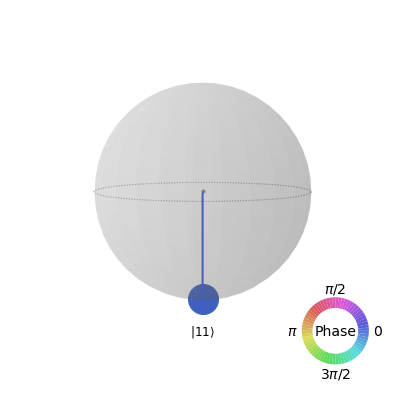

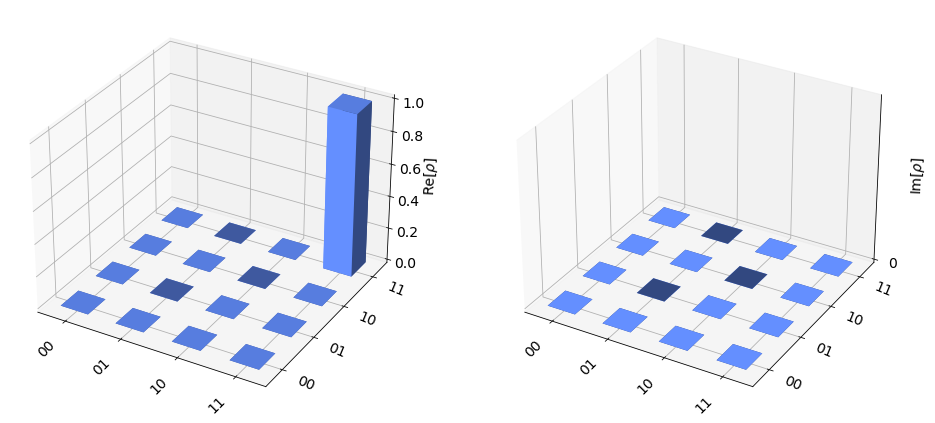

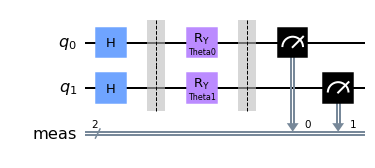

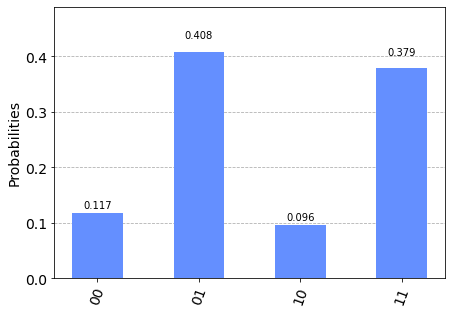

In [2]:
class AdhocCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots, n_input=9):
        # --- Circuit definition ---
        self.n_qubits=n_qubits
        self.n_inputs = n_input
        # all_qubits = [i for i in range(n_qubits)]
        # self._circuit = qiskit.QuantumCircuit(self.n_qubits)
        # self.thetas ={k : Parameter('Theta'+str(k))for k in range(self.n_qubits)}



        # self.theta = qiskit.circuit.Parameter('theta')
        # self._circuit.h(0)
        # self._circuit.cx(0, 1)
        # self._circuit.u(pi/4, -pi/3, pi/8, 1)
        # self._circuit.cx(0, 1)
        # self._circuit.h(0)

        # self._circuit.barrier()
        # for k in range(n_qubits):
        #     self._circuit.ry(self.thetas[k], k)
        # self._circuit.ry(self.theta, 1)

        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas ={k : Parameter('Theta'+str(k))for k in range(self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)



        # self._circuit.measure(0, 0)
        self.circuit.measure_all()

        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def forward(self, input):
        t_qc = transpile(self.circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        # parameter_binds = [{self.theta: theta.item()} for theta in thetas])
                        parameter_binds = [{self.thetas[k] : input[k].item() for k in range(self.n_qubits)}])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        # exp = []
        # for dict_ in result:
        counts = np.array(list(result.values()))
        states = np.array([int(k, 2) for k in list(result.keys())])
        probabilities = counts / self.shots
        expectation = states * probabilities
        #     # print(expectation)
        # #     # while len(expectation)<2**self.n_qubits:
        # #     #   np.append(expectation,0)
        #     exp.extend(expectation)
   
        while expectation.shape[0]<2**self.n_qubits:
            expectation = np.append(expectation, 0.0001)
          
        # return np.asarray(exp).T
        return expectation
    def plot(self, input):
        self.plot_backend = qiskit.Aer.get_backend("statevector_simulator")
        t_qc = transpile(self.circuit,
                         self.plot_backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        # parameter_binds = [{self.theta: theta.item()} for theta in thetas])
                        parameter_binds = [{self.thetas[k] : input[k].item() for k in range(self.n_qubits)}])

        job = self.plot_backend.run(qobj)
        result = job.result().get_counts()
        display(plot_state_qsphere(job.result().get_statevector()))
        display(plot_state_city(job.result().get_statevector(), figsize=[16, 9]))
        display(self.circuit.draw("mpl"))
        display(plot_histogram(job.result().get_counts()))


simulator = qiskit.Aer.get_backend('aer_simulator')
circuit = AdhocCircuit(2, simulator, 512)
print('Expected value for rotation pi {}'.format(circuit.forward(torch.rand(2))))

circuit.plot(torch.rand(2))


Expected value for rotation pi [0.         0.859375   0.72070312 0.         0.         0.72851562
 0.         0.73046875 0.55078125 0.         0.         0.7890625
 0.         0.57421875 0.         0.70703125 0.         0.921875  ]


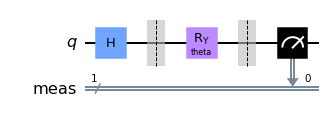

In [3]:
class AdhocCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots, n_input=9):
        # --- Circuit definition ---
        # self._circuit = qiskit.QuantumCircuit(2,  2)
        # # self._circuit = qiskit.QuantumCircuit(n_qubits, 1)

        self.n_qubits=n_qubits
        self.n_inputs = n_input
        # all_qubits = [i for i in range(n_qubits)]
        # self.theta = qiskit.circuit.Parameter('theta')
        # self._circuit.ry(self.theta, 1)

        # self._circuit.h(0)
        # self._circuit.cx(0, 1)
        # self._circuit.u(pi/4, -pi/3, pi/8, 1)
        # # self._circuit.cx(0, 1)
        # # self._circuit.h(0)

        
        # # self._circuit.ry(self.theta, 0)




        # self._circuit.measure(1, 0)
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.theta = qiskit.circuit.Parameter('theta')
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        self.circuit.ry(self.theta, all_qubits)

        self.circuit.measure_all()

        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def forward(self, thetas):
        t_qc = transpile(self.circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta.item()} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()

        # add noise

        
        exp = []
        for dict_ in result:
            counts = np.array(list(dict_.values()))
            states = np.array([int(k, 2) for k in list(dict_.keys())])
            probabilities = counts / self.shots
            expectation = states * probabilities

            exp.extend(expectation)
   
        while len(exp)<self.n_inputs*2**self.n_qubits:
          exp.extend([0.00])
        return np.asarray(exp).T
    def plot(self, thetas):
        self.plot_backend = qiskit.Aer.get_backend("statevector_simulator")
        t_qc = transpile(self._circuit,
                         self.plot_backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta.item()} for theta in thetas])
        job = self.plot_backend.run(qobj)
        result = job.result().get_counts()
        display(plot_state_qsphere(job.result().get_statevector()))
        display(plot_state_city(job.result().get_statevector(), figsize=[16, 9]))
        display(self._circuit.draw("mpl"))
        display(plot_histogram(job.result().get_counts()))


simulator = qiskit.Aer.get_backend('aer_simulator')
circuit = AdhocCircuit(1, simulator, 512)
print('Expected value for rotation pi {}'.format(circuit.forward(torch.rand(9))))
circuit.circuit.draw('mpl')
# circuit.plot(torch.rand(9))


In [4]:
import random

def set_seed_everything(seed: int):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed = 10599

set_seed_everything(seed)

import pandas as pd
def readData(dir):
    training_Data = pd.read_csv(dir)

    return training_Data
def normalize_data(data):
    cell = data.iloc[:, 0:589]
    data.iloc[:, 0:589] = np.where(cell <= 0, (cell + 100)/100, 0)

    columns_removed = ['User_ID', 'Phone_type', 'Time']
    for col in columns_removed:
        data.drop(col, axis=1, inplace=True)

    return data
    
def separates_data(data):
    _X = data.drop(['Pos_x', 'Pos_y', 'Floor_ID', 'Building_ID'], axis=1)
    # _y = data[['Pos_x', 'Pos_y', 'Floor_ID', 'Building_ID']]
    _y = data[['Pos_x', 'Pos_y']]
    _z = data[['Floor_ID']]
    _X = _X.to_numpy()
    _y = _y.to_numpy()
    _z = _z.to_numpy()

    return _X, _y, _z.reshape(-1, ).astype('int64') + 3

In [5]:
from sklearn.decomposition import KernelPCA
def loadCsv(theFile):
    theArray = np.genfromtxt(theFile, delimiter=";", skip_header=0)
    return theArray

def load_data(trainFile,testFile,delim,skiphd):
    train = np.genfromtxt(trainFile, delimiter=delim,skip_header=skiphd)
    test = np.genfromtxt(testFile, delimiter=delim,skip_header=skiphd)
    X_train=train[:,0:589]
    X_train[X_train==100]=0
    Y_train=train[:,589:591]
    X_test=test[:,0:589]
    X_test[X_test==100]=0
    Y_test=test[:,589:591]
             
    return X_train,Y_train,X_test,Y_test

data_train_dir = 'UTSIndoorLoc/UTS_training.csv'
data_test_dir = 'UTSIndoorLoc/UTS_test.csv'
trainingData = readData(data_train_dir)
testData = readData(data_test_dir)
# normalize data
trainingData = normalize_data(trainingData)
testData = normalize_data(testData)
X_train, Y_train, Z_train = separates_data(trainingData)
X_test, Y_test, Z_test = separates_data(testData)



scX = StandardScaler()

pca = KernelPCA(n_components=64, kernel="cosine")

X_train = scX.fit_transform(X_train)
# X_test = scX.transform(X_test)
X_test = scX.transform(X_test)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


print('X_train:', X_train.shape)
# print('X_test:', X_test.shape)
print('X_test:', X_test.shape)


train_cluster_data = RSSIDataset(X_train, Y_train)
test_cluster_data = RSSIDataset(X_test, Y_test)

from torch.utils.data import DataLoader

n_cpu = os.cpu_count()

train_cluster_dataloader = DataLoader(train_cluster_data, batch_size=16, shuffle=True, num_workers=n_cpu)
test_cluster_dataloader = DataLoader(test_cluster_data, batch_size=1, shuffle=False, num_workers=n_cpu)



dataset_sizes = {'train': len(train_cluster_data), 'val':len(test_cluster_data)}
dataloaders = {'train':train_cluster_dataloader, 'val':test_cluster_dataloader}

# Display image and label.
train_features, train_labels = next(iter(train_cluster_dataloader))
test_features, test_labels = next(iter(test_cluster_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

X_train: (9108, 64)
X_test: (388, 64)
Feature batch shape: torch.Size([16, 64])
Labels batch shape: torch.Size([16, 2])


In [6]:
NUM_INP=4
NUM_OUT=2
NUM_QUBITS = 2
SIMULATOR=qiskit.Aer.get_backend('aer_simulator')

NUM_SHOTS=512
SHIFT = np.pi/2

class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, inp, circuit=None, shift=np.pi/2):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = AdhocCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS, n_input=NUM_INP)
            
        exp_value = ctx.QiskitCirc.forward(inp)
        
        result = torch.tensor([exp_value])
        
        ctx.save_for_backward(result, inp)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
        input_numbers = i
        gradients = torch.Tensor()
        
        for k in range(NUM_INP):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
            
            expectation_right = ctx.QiskitCirc.forward(shift_right)
            expectation_left  = ctx.QiskitCirc.forward(shift_left)
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients = torch.cat((gradients, gradient.float()))
        result = torch.Tensor(gradients)

        return (result.float() * grad_output.float()).T





x1 = torch.tensor([0.0624]*NUM_INP, requires_grad=True)


qc = TorchCircuit.apply
y1 = qc(x1)
print(y1)
print('y1 after quantum layer: {}'.format(y1.shape))

y1 = nn.Linear(2**NUM_QUBITS*NUM_INP,1)(y1.float())
y1.backward()

print('x.grad = {}'.format(x1.grad))


tensor([[0.2500, 0.4883, 0.0000, 0.8730, 0.2773, 0.4648, 0.0000, 0.8848, 0.2324,
         0.8848, 0.5469, 0.0000, 0.2363, 0.5234, 0.0000, 0.8496]],
       dtype=torch.float64, grad_fn=<TorchCircuitBackward>)
y1 after quantum layer: torch.Size([1, 16])


/tmp/ipykernel_16065/835092392.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755898319/work/torch/csrc/utils/tensor_new.cpp:210.)
  result = torch.tensor([exp_value])


x.grad = tensor([-0.0111,  0.6255, -0.5671,  0.1871])


100%|██████████| 50/50 [00:55<00:00,  1.12s/it]


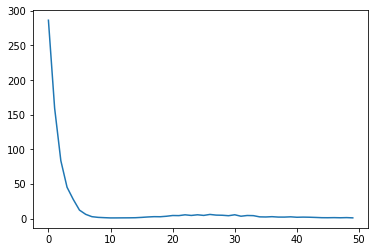

In [7]:


from tqdm import tqdm
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)[0]
    
    # simple linear layer: average all outputs of quantum layer
#     print(expval)
    val = sum([(i+1)*expval[i] for i in range(2**NUM_QUBITS*NUM_INP)]) / 2**NUM_QUBITS*NUM_INP
#     print(val)
    return torch.abs(val - target) ** 2, expval

x = torch.tensor([-np.pi/4]*NUM_INP, requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 50

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
# for i in range(num_epoch):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)

plt.plot(loss_list)

In [8]:
#uncomment when retrain new model


class Net(nn.Module):
    def __init__(self, quantum=True, quantum_root=False, num_classes=NUM_OUT):
        super(Net, self).__init__()
        self.quantum_root = quantum_root
        self.quantum = quantum
        self.fc_in = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, NUM_INP),
            nn.BatchNorm1d(NUM_INP),
            torch.nn.ReLU(),
            nn.Dropout(0.3),
        )
        self.init_weight()
        self.qc1 = TorchCircuit.apply

        self.classical = nn.Linear(NUM_INP, num_classes)

        self.pre_out = nn.Linear(2**NUM_QUBITS*NUM_INP, 4)
        self.pre_bn = nn.BatchNorm1d(4)
        self.fc_out = nn.Linear(4, num_classes)
        
    def init_weight(self):
        for m in self.modules():
          if m.__class__.__name__.startswith('Linear'):
              torch.nn.init.xavier_normal_(m.weight)
              m.bias.data.fill_(0.0001)

    def forward(self, x):

      
        if self.quantum_root:
            x = self.quantum_layer(x)
            x = self.fc_in(x.float())
            x = self.classical(x)
        else:

            x = self.fc_in(x)
            if self.quantum:
                # x = torch.tanh(x)*np.pi/2.
                q_out = torch.cat([self.qc1(x_i) for x_i in x])
                x = F.relu(self.pre_bn(self.pre_out(q_out.float())))

                x = F.relu(self.fc_out(x))
            else:
                x = self.classical(x)
        return x

net = Net(quantum=True, quantum_root=False)
a = torch.rand((8, 64))
out = net(a)
out.shape

torch.Size([8, 2])

In [9]:
from tqdm import tqdm
def clip_gradient(optimizer, grad_clip):
    """
    For calibrating misalignment gradient via cliping gradient technique
    :param optimizer:
    :param grad_clip:
    :return:
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

def meanError(A, B):
    tot = 0.
    errA = np.zeros(A.shape[0])
    for i in range(A.shape[0]):
        mtot = np.linalg.norm((A[i] - B[i]))
        errA[i] = mtot
    return errA.mean(),errA

def train():
    model = Net(quantum=True, quantum_root=False)
    epochs = 30
    loss_list = []
    loss_eval = []
    best_test_loss = 100
    clip = 0.5

    model.train()
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9, nesterov=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.004, weight_decay=0.001)
    decayRate = 0.96

    my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

    loss_func = MeanLoss()


    for epoch in range(1,epochs+1):
        total_loss = []
        with tqdm(train_cluster_dataloader, unit="batch") as tepoch:
          for i, (data, target) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch} train")
            optimizer.zero_grad()
            # Forward pass
            output = model(data.float())

            # Calculating loss
            loss = loss_func(output.float(), target.float())
            # Backward pass
            loss.backward()
            # Optimize the weights
            clip_gradient(optimizer, clip)
            optimizer.step()
            total_loss.append(loss.item())
            tepoch.set_postfix( AVG_LOSS = sum(total_loss)/len(total_loss), LOSS_ITER = loss.item())

          my_lr_scheduler.step()
          loss_list.append(sum(total_loss)/len(total_loss))

          # print('\nTrain set: Average loss: {:.4f}'.format(loss_list[-1]))
        

        if epoch%1==0:
            test_loss = 0
            with torch.no_grad():
                model.eval()
                with tqdm(test_cluster_dataloader, unit="batch") as vepoch:
                    for inputs, labels in vepoch:
                      vepoch.set_description(f"Epoch {epoch} val")
                      outputs = model(inputs.float())

                      
                      loss = loss_func(outputs, labels)
                      
                      test_loss += loss.item()
                      vepoch.set_postfix(AVG_LOSS = test_loss/len(test_cluster_dataloader), LOSS_ITER = loss.item())
                    test_loss /= len(test_cluster_dataloader)
                    loss_eval.append(test_loss)

                    
                    
                    if test_loss < best_test_loss:
                        best_test_loss = test_loss
                        best_weight = model.state_dict()
                        weight_path = '/home/kiosk/Desktop/Quantum/data-code-1/checkpoints/model_quantum.pth'
                        torch.save(best_weight, weight_path)
                        print('  '*50, 'Best valid loss: {:.4f}'.format(best_test_loss))
    return loss_list, loss_eval, weight_path
loss_list, loss_eval, weight = train()


loss_func = MeanLoss()
results = np.array([]).reshape(0,2)
lbs = np.array([]).reshape(0,2)
model = Net(quantum=True, quantum_root=False)
model.load_state_dict(torch.load(weight))
model.eval()
l = 0
for inputs, labels in test_cluster_dataloader:
    outputs = model(inputs.float())
    loss = loss_func(outputs, labels)
    l += loss.detach().numpy()
    results = np.concatenate((results, outputs.detach().cpu().numpy()), axis=0)
    lbs = np.concatenate((lbs, labels.detach().cpu().numpy()), axis=0)
    

print("Pytorch euclide loss: ", l/len(test_cluster_dataloader))

results = np.asarray(results)
lbs = np.asarray(lbs)

err_mean, err = meanError(results, lbs)
print("Numpy euclide loss: ", err_mean)

Epoch 1 val: 100%|██████████| 388/388 [00:55<00:00,  6.93batch/s, AVG_LOSS=25.6, LOSS_ITER=65]   


                                                                                                     Best valid loss: 25.5653


Epoch 2 val: 100%|██████████| 388/388 [00:56<00:00,  6.90batch/s, AVG_LOSS=9.24, LOSS_ITER=5.62] 


                                                                                                     Best valid loss: 9.2378


Epoch 5 val: 100%|██████████| 388/388 [00:59<00:00,  6.52batch/s, AVG_LOSS=8.52, LOSS_ITER=14.3] 


                                                                                                     Best valid loss: 8.5150


Epoch 6 val: 100%|██████████| 388/388 [00:59<00:00,  6.54batch/s, AVG_LOSS=8.09, LOSS_ITER=7.55] 


                                                                                                     Best valid loss: 8.0876


Epoch 7 val: 100%|██████████| 388/388 [00:59<00:00,  6.57batch/s, AVG_LOSS=8.03, LOSS_ITER=9.37] 


                                                                                                     Best valid loss: 8.0284


Epoch 10 val: 100%|██████████| 388/388 [00:52<00:00,  7.38batch/s, AVG_LOSS=7.82, LOSS_ITER=6.4]  


                                                                                                     Best valid loss: 7.8165


Epoch 11 val: 100%|██████████| 388/388 [00:51<00:00,  7.47batch/s, AVG_LOSS=7.42, LOSS_ITER=6.96] 


                                                                                                     Best valid loss: 7.4228


Epoch 14 val: 100%|██████████| 388/388 [01:01<00:00,  6.28batch/s, AVG_LOSS=7.23, LOSS_ITER=5.9]  


                                                                                                     Best valid loss: 7.2309


Epoch 23 train:  28%|██▊       | 162/570 [51:22<2:10:09, 19.14s/batch, AVG_LOSS=4.66, LOSS_ITER=4.11]